## Lista de Exercícios #12: Redes Neurais Convolucionais (CNN)

**Aluno:** Samuel Horta de Faria

**Matrícula:** 801528

**Curso:** Ciência da Computação
**Disciplina:** Inteligência Artificial

**Profª:** Cristiane Neri Nobre

Este notebook implementa uma Rede Neural Convolucional (CNN) para resolver o problema de classificação de imagens da competição 'Dogs vs. Cats' do Kaggle. O objetivo é construir um modelo capaz de diferenciar imagens de cachorros e gatos. As etapas incluem a preparação dos dados, a construção da arquitetura da CNN e o treinamento do modelo.

### 0. Configurações Iniciais e Imports

Importação de todas as bibliotecas necessárias. Utilizaremos `matplotlib` para visualização e `tensorflow.keras` para construir e treinar nossa CNN.

In [4]:
# Imports para manipulação de dados e sistema operacional
import numpy as np
import pandas as pd
import os
import random

# Imports para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Imports do TensorFlow e Keras para a construção da CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import para divisão de dados
from sklearn.model_selection import train_test_split

# Configuração para exibir gráficos no notebook
%matplotlib inline

### 1. Definição de Constantes e Caminhos


In [5]:
# --- Caminhos das imagens (DESCOMPACTANDO O ARQUIV .ZIP) ---

# Cria as pastas onde as imagens serão descompactadas
!mkdir -p /content/dogs-vs-cats/train
!mkdir -p /content/dogs-vs-cats/test1

# Descompacta os arquivos zip
!ls -lh train.zip
!ls -lh test1.zip

!unzip -q -o train.zip -d /content/dogs-vs-cats/train
!unzip -q -o test1.zip -d /content/dogs-vs-cats/test1

TRAIN_DIR = '/content/dogs-vs-cats/train/train'
TEST_DIR = '/content/dogs-vs-cats/test1/test1'

# Constantes para o modelo
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3 # 3 para imagens coloridas (RGB)
BATCH_SIZE = 32 # Número de imagens processadas por lote

-rw-r--r-- 1 root root 544M Jun 13 19:46 train.zip
-rw-r--r-- 1 root root 272M Jun 13 19:44 test1.zip


### 2. Preparação dos Dados de Treino

Os dados de treino estão em uma única pasta, com os nomes dos arquivos indicando a classe. Será lido todos os nomes de arquivos, extrair suas classes e organizar essas informações em um DataFrame do pandas para facilitar a manipulação.

In [6]:
# Lista para armazenar nomes de arquivos e suas categorias
filenames = os.listdir(TRAIN_DIR)
categories = []

# Loop para extrair a categoria do nome do arquivo
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('dog') # Usando strings para facilitar a divisão
    else:
        categories.append('cat')

# Criação do DataFrame
train_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

print("---| DataFrame de Treino Criado |---")
print(f"Total de imagens de treino: {train_df.shape[0]}")
print(train_df.head())

print("\n---| Distribuição das Classes |---")
print(train_df['category'].value_counts())

---| DataFrame de Treino Criado |---
Total de imagens de treino: 25000
       filename category
0  dog.1612.jpg      dog
1  cat.5027.jpg      cat
2  dog.3217.jpg      dog
3  dog.9772.jpg      dog
4  cat.8286.jpg      cat

---| Distribuição das Classes |---
category
dog    12500
cat    12500
Name: count, dtype: int64


### 3. Divisão dos Dados e Geração de Lotes (Batches)

Divisão do conjunto de treino em dois: um para treinamento (90%) e outro para validação (10%). A validação ajuda a monitorar se o modelo está sofrendo de overfitting.

Uso de `ImageDataGenerator` do Keras para:
1.  **Aumento de Dados (Data Augmentation):** Criar variações das imagens de treino (rotações, zooms, etc.) para tornar o modelo mais robusto.
2.  **Geração de Lotes:** Carregar as imagens da memória de forma eficiente em lotes, redimensionando-as e normalizando os valores dos pixels (dividindo por 255).

In [7]:
# Divisão do DataFrame em treino e validação
train_df, validate_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

print("---| Tamanho dos Conjuntos Após a Divisão |---")
print(f"Treino: {train_df.shape[0]} imagens")
print(f"Validação: {validate_df.shape[0]} imagens")

# Gerador para dados de treino com Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Gerador para dados de validação
validation_datagen = ImageDataGenerator(rescale=1./255.)

# Criando os geradores que lerão as imagens a partir do DataFrame
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    TRAIN_DIR,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary', # Classificação binária (gato | cachorro)
    batch_size=BATCH_SIZE
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    TRAIN_DIR,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

---| Tamanho dos Conjuntos Após a Divisão |---
Treino: 22500 imagens
Validação: 2500 imagens
Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


### 4. Construção do Modelo CNN

Definição da arquitetura da nossa CNN. O modelo será sequencial e composto por:
- **Camadas Convolucionais (`Conv2D`):** Responsáveis por extrair características das imagens.
- **Camadas de Pooling (`MaxPooling2D`):** Reduzem a dimensionalidade dos mapas de características, mantendo as informações mais importantes.
- **Camada Flatten:** Transforma a matriz 2D de características em um vetor 1D para ser processado pela parte final da rede.
- **Camadas Densas (`Dense`):** Camadas totalmente conectadas que realizam a classificação com base nas características extraídas.
- **Camada de Dropout:** Técnica de regularização para prevenir overfitting, "desligando" aleatoriamente alguns neurônios durante o treino.
- **Funções de Ativação:** `relu` para as camadas ocultas e `sigmoid` para a camada de saída, pois temos uma classificação binária.

In [8]:
model = Sequential()

# Bloco 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Bloco 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Bloco 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Camada de achatamento e camadas densas
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5)) # Dropout para regularização
model.add(Dense(1, activation='sigmoid')) # Saída com sigmoid para classificação binária

# Compilação do modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("---| Resumo da Arquitetura do Modelo |---")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


---| Resumo da Arquitetura do Modelo |---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,329 (49.36 MB)

 Trainable params: 12,939,329 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Treinamento do Modelo

Após modelo de geradores de dados pronto, inicia-se o treinamento usando o método `fit()`. Ocorrerá por um número definido de `epochs` (épocas). Em cada época, o modelo verá todas as imagens do conjunto de treino.

In [9]:
EPOCHS = 3

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validate_df.shape[0] // BATCH_SIZE,
    steps_per_epoch=train_df.shape[0] // BATCH_SIZE
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5773 - loss: 0.6889

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


703/703 ━━━━━━━━━━━━━━━━━━━━ 1007s 1s/step - accuracy: 0.5773 - loss: 0.6889 - val_accuracy: 0.6939 - val_loss: 0.5796
Epoch 2/3
  1/703 ━━━━━━━━━━━━━━━━━━━━ 12:36 1s/step - accuracy: 0.6875 - loss: 0.6281

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


703/703 ━━━━━━━━━━━━━━━━━━━━ 41s 57ms/step - accuracy: 0.6875 - loss: 0.6281 - val_accuracy: 0.6955 - val_loss: 0.5780
Epoch 3/3
239/703 ━━━━━━━━━━━━━━━━━━━━ 10:47 1s/step - accuracy: 0.6904 - loss: 0.5902

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1880: DeprecationWarning: Please import `affine_transform` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  scipy.ndimage.interpolation.affine_transform(


703/703 ━━━━━━━━━━━━━━━━━━━━ 1102s 1s/step - accuracy: 0.7001 - loss: 0.5784 - val_accuracy: 0.7712 - val_loss: 0.4868


### 6. Avaliação do Modelo

Após treinamento, avalia-se o desempenho. Será plotado a acurácia e a perda (loss) do treino e da validação ao longo das épocas. Permitindo visualizar o aprendizado e identificar sinais de overfitting.

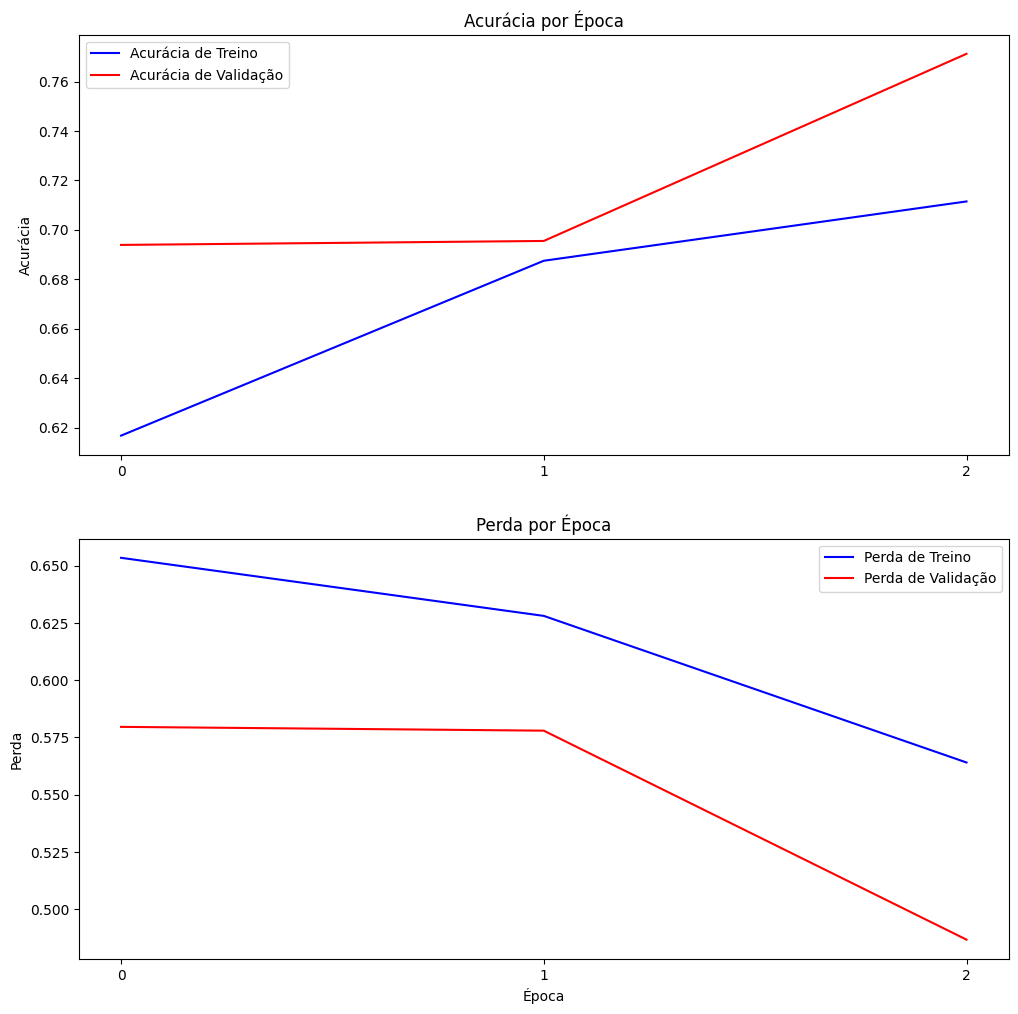

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Gráfico da Acurácia
ax1.plot(history.history['accuracy'], color='b', label="Acurácia de Treino")
ax1.plot(history.history['val_accuracy'], color='r', label="Acurácia de Validação")
ax1.set_xticks(np.arange(0, EPOCHS, 1))
ax1.set_ylabel('Acurácia')
ax1.set_title('Acurácia por Época')
ax1.legend()

# Gráfico da Perda
ax2.plot(history.history['loss'], color='b', label="Perda de Treino")
ax2.plot(history.history['val_loss'], color='r', label="Perda de Validação")
ax2.set_xticks(np.arange(0, EPOCHS, 1))
ax2.set_ylabel('Perda')
ax2.set_xlabel('Época')
ax2.set_title('Perda por Época')
ax2.legend()

plt.show()

### 7. Preparação dos Dados de Teste e Geração da Conclusão

Por ultimo, será usado o modelo treinado para prever as classes das imagens no conjunto de teste. Semelhante ao de validação: cria-se um DataFrame para os arquivos de teste e um gerador para carregá-los e normalizá-los. As previsões do modelo (probabilidades entre 0 e 1) são então convertidas para as classes finais (0 para 'gato', 1 para 'cachorro') e formatadas em um arquivo .csv.

In [13]:
# Preparando o DataFrame de teste
test_filenames = os.listdir(TEST_DIR)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

# Gerador para os dados de teste
test_gen = ImageDataGenerator(rescale=1./255.)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    TEST_DIR,
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Realizando as predições
predict = model.predict(test_generator, steps=int(np.ceil(nb_samples/BATCH_SIZE)))

# Convertendo probabilidades em classes (0 ou 1)
# A classe 'dog' é 1, 'cat' é 0. O sigmoid > 0.5 indica maior probabilidade de ser a classe 1.
test_df['category'] = np.where(predict > 0.5, 1, 0)


print("\n---| Exemplo de Predições no Conjunto de Teste |---")
print(test_df.head())

Found 12500 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 143s 366ms/step

---| Exemplo de Predições no Conjunto de Teste |---
   filename  category
0  3540.jpg         0
1  9604.jpg         1
2  7200.jpg         0
3   877.jpg         0
4  5729.jpg         0


### 8. Conclusão sobre o Desempenho do Modelo

Com base nos gráficos de acurácia e perda gerados após o treinamento por 3 épocas, podemos observar o seguinte:

*   **Acurácia:** A acurácia tanto no conjunto de treino quanto no conjunto de validação aumentou ao longo das épocas, indicando que o modelo está aprendendo a classificar as imagens. A acurácia de validação alcançou aproximadamente 77.12%, o que sugere que o modelo tem alguma capacidade de generalização para dados não vistos.
*   **Perda (Loss):** A perda diminuiu em ambos os conjuntos, o que é um bom sinal de que o modelo está convergindo. A perda de validação diminuiu para aproximadamente 0.4868.

Embora o modelo tenha demonstrado aprendizado, há espaço para melhorias. A diferença entre a acurácia de treino e validação, embora não seja drástica, pode indicar um leve overfitting. Treinar por mais épocas, ajustar a arquitetura da rede ou experimentar com diferentes técnicas de regularização podem potencialmente melhorar o desempenho e a capacidade de generalização do modelo.